In [10]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
from word2number import w2n
import matplotlib
import warnings
warnings.filterwarnings("ignore")

# convert column's dtype from an object to datetime
def datCnv(src):
    return pd.to_datetime(src)

# checks if column contains number in string  
def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

# convert numbers written in alphabetical characeters to a numberic value 
def convert_word_to_number(word):
    word = word.lower()
    number = w2n.word_to_num(word)
    return number 

#CALCULATING PROFIT,COSTS,REVENUE
def calculate_profit(agg):
    #arrival and departure delay costs on the first half of the round trip flight
    agg['DEP_DELAY_mean_cost'] = (agg['DEP_DELAY_mean'] - 15)*75
    agg['DEP_DELAY_mean_cost'] = np.where(agg.DEP_DELAY_mean_cost < 0, 0, agg.DEP_DELAY_mean_cost)
    agg['ARR_DELAY_mean_cost'] = (agg['ARR_DELAY_mean'] - 15)*75
    agg['ARR_DELAY_mean_cost'] = np.where(agg.ARR_DELAY_mean_cost < 0, 0, agg.ARR_DELAY_mean_cost)
    
    #arrival and departure delay costs on second half of the round trip flight
    agg['NEXT_DEP_DELAY_mean_cost'] = (agg['NEXT_DEP_DELAY_mean'] - 15)*75
    agg['NEXT_DEP_DELAY_mean_cost'] = np.where(agg.NEXT_DEP_DELAY_mean_cost < 0, 0, agg.NEXT_DEP_DELAY_mean_cost)
    agg['NEXT_ARR_DELAY_mean_cost'] = (agg['NEXT_ARR_DELAY_mean'] - 15)*75
    agg['NEXT_ARR_DELAY_mean_cost'] = np.where(agg.NEXT_ARR_DELAY_mean_cost < 0, 0, agg.NEXT_ARR_DELAY_mean_cost)
    
    #other sources of costs and revenue based on the assumptions given
    agg['FOMC_cost'] = agg['DISTANCE_mean']*8
    agg['DIO_cost'] = agg['DISTANCE_mean']*1.18
    agg['NO_PASSENGERS_mean'] = (agg['OCCUPANCY_RATE_mean']*200).astype(int)
    agg['BAGGAGE_mean_revenue'] = agg['NO_PASSENGERS_mean']*0.5*70
    agg['ITIN_mean_revenue'] = agg['NO_PASSENGERS_mean']* agg['ITIN_FARE_median']
    agg['TOTAL_REVENUE_mean'] = agg['BAGGAGE_mean_revenue'] + agg['ITIN_mean_revenue']
    agg['TOTAL_operational_cost'] = agg['ORIGIN_op_cost'] + agg['DESTINATION_op_cost']
    agg['TOTAL_COST_mean'] = agg['DEP_DELAY_mean_cost'] + agg['ARR_DELAY_mean_cost'] + agg['TOTAL_operational_cost'] + agg['FOMC_cost'] + agg['NEXT_DEP_DELAY_mean_cost'] +agg['NEXT_ARR_DELAY_mean_cost']
    agg['TOTAL_PROFIT_mean'] = agg['TOTAL_REVENUE_mean'] - agg['TOTAL_COST_mean']
    agg = agg.sort_values(by='TOTAL_PROFIT_mean', ascending=False)
    return agg


#include only round trip flights using the tickets dataset
def process_tickets_dataset(dataset):
    dataset = dataset[dataset.ROUNDTRIP == 1.0]
    dataset['ITIN_FARE'] = dataset['ITIN_FARE'].str.replace("$","").astype(float)
    dataset = dataset[['ORIGIN','DESTINATION','ITIN_FARE']]
    return dataset

#process flights dataset
def process_flights(flights,airport_codes):
    #exclude canceled flights and drop the cancelled column
    flights = flights.drop(columns=['OP_CARRIER','ORIGIN_AIRPORT_ID','OP_CARRIER_FL_NUM','ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID','DEST_CITY_NAME','AIR_TIME'],axis=1)
    flights = flights[flights['CANCELLED'] == 0.0].drop(columns=['CANCELLED'],axis=1)

    #classify airport size of the airport of the columns ORIGIN and Destination of the flights dataset
    airport_codes = airport_codes.rename(columns={"IATA_CODE": "ORIGIN"})
    flights =  pd.merge(flights,airport_codes,how='inner',on='ORIGIN')
    airport_codes = airport_codes.rename(columns={"ORIGIN": "DESTINATION"})
    flights =  pd.merge(flights,airport_codes,how='inner',on='DESTINATION')
    flights = flights.rename(columns={"TYPE_x": "ORIGIN_TYPE",'TYPE_y':"DESTINATION_TYPE"})

    #convert FL_DATE column into datetime64[ns] Dtype
    flights['FL_DATE'] = flights.FL_DATE.apply(datCnv)

    #sort flights dataset by ascending order based on the date(FL_DATE)
    flights = flights.sort_values(by='FL_DATE',ascending=True)
    flights['DISTANCE']  = flights['DISTANCE'].replace(['****','NAN'], np.nan)
    flights['has_number'] = flights.apply(lambda x: has_numbers(str(x.DISTANCE)), axis=1)
    distance_words = list(np.unique(list(flights[~flights['has_number']]['DISTANCE'].dropna())))
    for word in distance_words:
        flights['DISTANCE']  = flights['DISTANCE'].replace(word, convert_word_to_number(word)) 
    flights['DISTANCE'] = flights['DISTANCE'].astype(float)
    flights['DISTANCE'] = round(2*flights['DISTANCE'])
    flights['starts_with_N'] = list(map(lambda x: x.startswith('N'), flights['TAIL_NUM']))     
    flights = flights[flights['starts_with_N']].drop(columns=['has_number','starts_with_N'])
    #count number of NaN values per column
    flights['ORIGIN_op_cost'] = np.where(flights['ORIGIN_TYPE'] == 'medium_airport',5000,10000)
    flights['DESTINATION_op_cost'] = np.where(flights['DESTINATION_TYPE'] == 'medium_airport',5000,10000)
    flights = flights.drop(columns=['ORIGIN_TYPE','DESTINATION_TYPE'])
    return flights

def filter_flights(flights):
    table = pd.DataFrame(columns = flights.columns)
    #list of the Tail Number of each unique plane 
    unique_plane_codes = list(np.unique(list(flights['TAIL_NUM'])))
    for plane_code in unique_plane_codes:
        #include round trip flights per unique plane using the TAIL
        flights_plane = flights[flights['TAIL_NUM']==plane_code]
        flights_shifted = flights_plane.shift(-1)

        #calculate delay time on the way back of the round trip
        flights_plane['NEXT_ARR_DELAY'] = flights_shifted['ARR_DELAY']
        flights_plane['NEXT_DEP_DELAY'] = flights_shifted['DEP_DELAY']

        #include only round trips
        flights_plane['NEXT_ORIGIN'] = flights_shifted['ORIGIN']
        flights_plane['NEXT_DESTINATION'] = flights_shifted['DESTINATION']
        #conditions_1 and condition_2 are based on the assumption stated above
        condition_1 = (flights_plane['NEXT_DESTINATION'] == flights_plane['ORIGIN'] ).astype(int)
        condition_2 = (flights_plane['NEXT_ORIGIN'] == flights_plane['DESTINATION']).astype(int)
        flights_plane['CON_1'] = condition_1
        flights_plane['CON_2'] = condition_2
        flights_plane['ROUND_TRIP'] = (flights_plane['CON_1'].astype(int) + flights_plane['CON_2'].astype(int))
        #if ROUND_TRIP equals to 2, the flight is a round trip
        flights_plane = flights_plane[flights_plane['ROUND_TRIP']==2]

        #drop irrelevant columns
        flights_plane = flights_plane.drop(columns=['NEXT_ORIGIN','NEXT_DESTINATION','CON_1', 'CON_2','ROUND_TRIP'],axis=1) 
        table = pd.concat([table,flights_plane])
    return table

## Flights dataset 
### Column description
Contains data about available routes from origin to destination. For
occupancy, use the data provided in this dataset. 

In [2]:
metadata = 'Airline_Challenge_Metadata.xlsx'
destination_folder = '../data/'
pd.set_option('display.max_colwidth', None)
flights_desc = pd.ExcelFile(destination_folder+metadata,engine='openpyxl').parse('Flights Metadata')
flights_desc

Field Name  \
0             FL_DATE   
1          OP_CARRIER   
2            TAIL_NUM   
3   OP_CARRIER_FL_NUM   
4   ORIGIN_AIRPORT_ID   
5              ORIGIN   
6    ORIGIN_CITY_NAME   
7     DEST_AIRPORT_ID   
8         DESTINATION   
9      DEST_CITY_NAME   
10          DEP_DELAY   
11          ARR_DELAY   
12          CANCELLED   
13           AIR_TIME   
14           DISTANCE   
15     OCCUPANCY_RATE   

                                                                                                   Description  
0                                                                                     Flight Date (yyyy-mm-dd)  
1                                                                     Operating commercial carrier Flight code  
2      Tail Number is the aircraft registration number for the aircraft used (similar to VIN number for cars).  
3                                                                   Operating commercial carrier Flight number  
4       Origin Airport, Airport ID. An identification number assigned by US DOT to identify a unique airport.   
5                                  Origin Airport, International Air Transport Association (IATA) Airport Code  
6                                                                                Origin Airport, City Name\t\t  
7   Destination Airport, Airport ID. An identification number assigned by US DOT to identify a unique airport.  
8                            Destination Airport, Operating commercial carrier Flight code (IATA )Airport Code  
9                                                                               Destination Airport, City Name  
10  Difference in minutes between scheduled and actual departure time. Early departures show negative numbers.  
11      Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers.  
12                   Cancelled Flight Indicator (1=Flight is cancelled).  Cancelled flights should be excluded  
13                                                                                 Flight Time, in Minutes\t\t  
14                                                   Distance between Origin and Destination Airports in Miles  
15                                                                                Occupancy rate of the flight

## Tickets dataset 
### Column description
Ticket prices data (sample data only as the data is huge). Consider
only round trips in your analysis.

In [3]:
pd.set_option('display.max_colwidth', None)
tickets_desc = pd.ExcelFile(destination_folder+metadata,engine='openpyxl').parse('Tickets Metadata')
tickets_desc

Field Name  \
0             ITIN_ID   
1                YEAR   
2             QUARTER   
3              ORIGIN   
4      ORIGIN_COUNTRY   
5    ORIGIN_STATE_ABR   
6     ORIGIN_STATE_NM   
7           ROUNDTRIP   
8   REPORTING_CARRIER   
9          PASSENGERS   
10          ITIN_FARE   
11        DESTINATION   

                                                                                                                                                                       Description  
0                                                                                                                                              Unique identifier for the itinerary  
1                                                                                                                                                            Year of the Itinerary  
2                                                                                                                                           Quarter Number (1-4) for the Itinerary  
3                                                                Origin Airport Code, International Air Transport Association Airport Code (IATA) which is unique for each airport  
4                                                                                                                                                    Country of the Origin Airport  
5                                                                                                                                              Origin Airport, State abbrevations.  
6                                                                                                                                                  Origin Airport, State Full Name  
7                                                                              Round Trip Indicator (1= Round Trip and 0 = One Way).  Consider only round trips for your analysis.  
8                                                                                                                                      2 character Reporting Airline Carrier codes  
9                                                                                                                                            Number of Passengers on the itinerary  
10  Itinerary Fare Per Person. Itinerary fare represents the whole round trip fare if ROUNDTRIP = 1. If ROUNDTRIP = 0, then the itinerary fare represents the one-way ticket fare.  
11                                                          Destination Airport Code, International Air Transport Association Airport Code (IATA) which is unique for each airport

## Airport dataset 
### Column description
Identifies whether an airport is considered medium or large
sized. Consider only medium and large airports in your analysis.

In [4]:
pd.set_option('display.max_colwidth', None)
airports_desc = pd.ExcelFile(destination_folder+metadata,engine='openpyxl').parse('Airport Codes Metadata')
airports_desc

Field Name  \
0          TYPE   
1          NAME   
2  ELEVATION_FT   
3     CONTINENT   
4   ISO_COUNTRY   
5  MUNICIPALITY   
6     IATA_CODE   
7   COORDINATES   

                                                                                                                                                                    Description  
0                                                                                     The type of the airport, valid value like: small_airport, medium_airport, heliport, etc.   
1                                                                                                                                                       The name of the airport  
2                                                                                                                                   Elevation of the airport from the sea level  
3                                                                                                                                              The continent airport belongs to  
4                                                                                                                                                    The country of the airport  
5                                                                                                                                              The city or town of the airport   
6  An airport code is a three-letter geocode designating many airports and metropolitan areas around the world, defined by the International Air Transport Association (IATA).   
7                                                                                                                             Longitude and latitude coordinates of the airport

### Exercise 1
The 10 busiest round trip routes in terms of number of round trip flights in the quarter.
Exclude canceled flights when performing the calculation.
#### Data Cleaning: Airports Dataset
The columns that are relevant for this analysis are <strong>TYPE</strong> and <strong>IATA_CODE</strong>. The airports dataset will be used to map the IATA_CODE column with the ORIGIN and DESTINATION column of the flights dataset. Due to the distriction of not being able to use any data other than what has been provided for this project, the best choice is to drop any columns that have NaN values in the IATA_CODE column.

In [11]:
#reading airports dataset
airport_codes = pd.read_csv( destination_folder + 'airport_codes.csv')[['TYPE','IATA_CODE']]
#drop rows where IATA_CODE is a NaN value
airport_codes = airport_codes[airport_codes['IATA_CODE'].notnull()]
#filtering for only medium and large size airports
airport_codes = airport_codes[(airport_codes['TYPE'] == 'medium_airport') | (airport_codes['TYPE'] == 'large_airport')]

print('Number of NaN values for each column of the airports dataset:')
print(airport_codes.isnull().sum(axis = 0))

Number of NaN values for each column of the airports dataset:
TYPE         0
IATA_CODE    0
dtype: int64


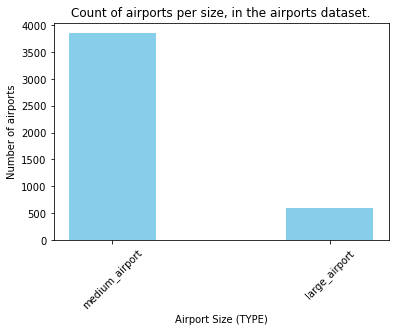

In [12]:
# creating the plot for counting the number of airports of large and medium size
airport_types = list(airport_codes.TYPE.value_counts().keys())
airport_counts = list(airport_codes.TYPE.value_counts())
airport_data = {'TYPE':airport_types, 'COUNTS':airport_counts }
airport_distribution = pd.DataFrame(data=airport_data)
plt.bar( airport_distribution.TYPE,airport_distribution.COUNTS , color ='skyblue', width = 0.4)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel("Airport Size (TYPE)")
plt.ylabel("Number of airports")
plt.title("Count of airports per size, in the airports dataset.")
plt.show()

#### Data Cleaning (Flights Dataset)

In [7]:
#read flights dataset, and drop irrelevant columns
flights = pd.read_csv(destination_folder + 'Flights.csv')
flights = process_flights(flights,airport_codes)

#check columns dtype
print('Column names and their corresponding Dtype')
print(flights.info())

#count number of NaN values per column
print('Number of NaN values for each column')
print(flights.isnull().sum(axis = 0))

Number of NaN values for each column
FL_DATE                0
TAIL_NUM               0
ORIGIN                 0
DESTINATION            0
DEP_DELAY              0
ARR_DELAY           4255
DISTANCE            2660
OCCUPANCY_RATE       310
ORIGIN_TYPE            0
DESTINATION_TYPE       0
dtype: int64
Column names and their corresponding Dtype
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1829596 entries, 1068001 to 744616
Data columns (total 10 columns):
 #   Column               Dtype         
---  ------               -----         
 0   FL_DATE              datetime64[ns]
 1   TAIL_NUM             object        
 2   ORIGIN               object        
 3   DESTINATION          object        
 4   DEP_DELAY            float64       
 5   ARR_DELAY            float64       
 6   DISTANCE             float64       
 7   OCCUPANCY_RATE       float64       
 8   ORIGIN_op_cost       int64         
 9   DESTINATION_op_cost  int64         
dtypes: datetime64[ns](1), float64(4), int64(2)

In [8]:
flights.head()

FL_DATE TAIL_NUM ORIGIN DESTINATION  DEP_DELAY  ARR_DELAY  \
1068001 2019-01-01   N896SK    FCA         SLC        1.0        5.0   
663556  2019-01-01   N225NN    GJT         DFW       -2.0       18.0   
663500  2019-01-01   N253NN    GJT         DFW        1.0       16.0   
1155692 2019-01-01   N8721J    PHX         HOU       -3.0      -15.0   
1155693 2019-01-01   N731SA    PHX         HOU        0.0        5.0   

         DISTANCE  OCCUPANCY_RATE  ORIGIN_op_cost  DESTINATION_op_cost  
1068001    1062.0            0.45            5000                10000  
663556     1546.0            0.82            5000                10000  
663500     1546.0            0.91            5000                10000  
1155692    2040.0            0.91           10000                10000  
1155693    2040.0            0.69           10000                10000

For this analysis, the following columns are being used:
- <strong>FL_DATE</strong> <br>
This variable consists of dates that are formatted differently. The two formats that were identified were year-month-day and month/day/year. This was solved by applying the datCnv function to the column.
- <strong>TAIL_NUM</strong> <br>
This column doesn't have any NaN values. Aircraft Tail Numbers are unique and each combination represents a different plane. A tail number is an alphanumeric code between two and six characters in length used to identify a specific airplane. The alphabetical prefix of a tail number is indicative of an airplane's country of origin. All United States-based tail numbers begin with “N". <br>
(Source: https://www.aircharteradvisors.com/what-are-tail-numbers/)
- <strong>DISTANCE</strong> <br>
Costs regarding fuel, oil, maintenance, crew, depreciation, insurance and others, are derived by multiplying the costs per mile with the distance between the two airports measured in miles. The NaN values 
- <strong>DEP_DELAY & ARR_DELAY</strong> <br>
Both variables are being used to calculate the cost that stem from delays in either departure or arrival. 
- <strong>ORIGIN_TYPE & DESTINATION_TYPE</strong> <br>
Both variables are being used to calculate the operational costs linked to the size of both the airport of origin and destination. 


<strong>Filling NaN values</strong> <br>
The ARR_DELAY, DISTANCE , and OCCUPANCY_RATE columns contain NaN values. They are filled at a later point with the mean of other instances of round trip flights that have identical ORIGIN and DESTINATION values.

#### Assumptions:
A flight can be considered as a round trip, if these two conditions are met:
1. The current flight's origin airport id is the same as the next flight's destination airport id
2. The next flight's origin airport id is the same as the current flight's airport destination id<br>
The terms "current" and "next" refers to the datapoint that corresponds to a flight. Flights are sorted by the FL_DATE dataset by ascending order.<br>

In [ ]:
df = filter_flights(flights)
df.to_csv('flights_filtered.csv')

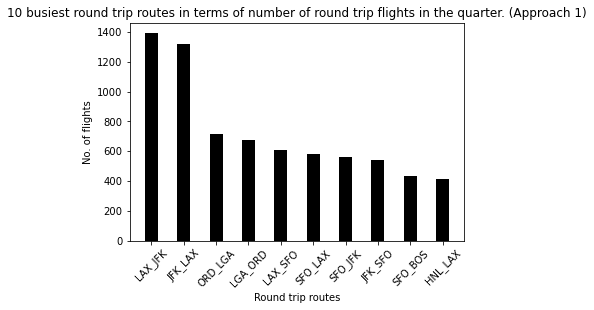

In [13]:
#reading filtered flights dataset
df = pd.read_csv('flights_filtered.csv',index_col=[0])

#count number of flights per round trip combination (Approach 1)
agg1 = df.groupby(['ORIGIN', 'DESTINATION']).size().reset_index().rename(columns={0:'NO_FLIGHTS'})
agg1['ORIGIN_DESTINATION'] = agg1['ORIGIN'] + '_' + agg1['DESTINATION']
# creating the bar plot
plt.bar(agg1.sort_values(by='NO_FLIGHTS', ascending=False).ORIGIN_DESTINATION[:10], agg1.sort_values(by='NO_FLIGHTS', ascending=False).NO_FLIGHTS[:10], color ='black',
        width = 0.4)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel("Round trip routes")
plt.ylabel("No. of flights")
plt.title("10 busiest round trip routes in terms of number of round trip flights in the quarter. (Approach 1)")
plt.show()

### Exercise 2
The 10 most profitable round trip routes (without considering the upfront airplane cost) in
the quarter. Along with the profit, show total revenue, total cost, summary values of
other key components and total round trip flights in the quarter for the top 10 most
profitable routes. Exclude canceled flights from these calculations.

#### Costs
1. Fuel, Oil, Maintenance, Crew - 8 USD per mile total
2. Depreciation, Insurance, Other - 1.18 USD per mile total
3. Airport operational costs for the right to use the airports and related services are fixed at 5000 USD for medium airports and 10000 USD for large airports. There is one charge for each airport where a flight lands. Thus, a round trip flight has a total of two airport charges.
4. For each individual departure, the first 15 minutes of delays are free, otherwise each minute costs the airline 75 USD in added operational costs.
5. For each individual arrival, the first 15 minutes of delays are free, otherwise each minute costs the airline 75 USD in added operational costs.


#### Revenue
1. Each plane can accommodate up to 200 passengers and each flight has an associated occupancy rate provided in the Flights data set. Do not use the Tickets data set to determine occupancy.
2. Baggage fee is 35 USD for each checked bag per flight. We expect 50% of passengers to check an average of 1 bag per flight. The fee is charged separately for each leg of a round trip flight, thus 50% of passengers will be
charged a total of 70 USD in baggage fees for a round trip flight.
3. Disregard seasonal effects on ticket prices (i.e. ticket prices are the same in April
as they are on Memorial Day or in December)

In [14]:
df = pd.read_csv('flights_filtered.csv',index_col=[0])

#count number of flights per round trip combination (Approach 1)
agg1 = df.groupby(['ORIGIN', 'DESTINATION']).size().reset_index().rename(columns={0:'NO_FLIGHTS'})

#calculating the mean of variables that contribute to the calculation of the total profit
means1 = df.groupby(['ORIGIN', 'DESTINATION']).agg({'DISTANCE': 'mean','NEXT_ARR_DELAY':'mean','NEXT_DEP_DELAY':'mean','DEP_DELAY': 'mean','ARR_DELAY': 'mean','OCCUPANCY_RATE': 'mean', 'ORIGIN_op_cost':'mean','DESTINATION_op_cost':'mean'}).reset_index()

#### Data cleaning (Tickets dataset)
The column that is beng used for aggregation is the <strong>ITIN_FARE</strong>. Seasonal effects can have either a significant positive or negative impact on the price of the ticket, therefore the median was chosen to calculate the itinerary fares. The median is a robust statistic because it has a breakdown point of 50%, as opposed to the mean which is more susceptible to extreme values. 

In [15]:
tickets = pd.read_csv( destination_folder + 'tickets.csv')
tickets = process_tickets_dataset(tickets)
itin_fare_median1 = tickets.groupby(['ORIGIN','DESTINATION'])['ITIN_FARE'].apply('median').reset_index().dropna()
itin_fare_median1['ORIGIN_DESTINATION'] = itin_fare_median1['ORIGIN'] + '_' + itin_fare_median1['DESTINATION']

In [16]:
agg1 = pd.merge(agg1,means1,on=['ORIGIN','DESTINATION'], how='left')
agg1 = pd.merge(agg1,itin_fare_median1,on=['ORIGIN','DESTINATION'], how='left').rename(columns={'DISTANCE':'DISTANCE_mean','DEP_DELAY':'DEP_DELAY_mean','ARR_DELAY':'ARR_DELAY_mean','OCCUPANCY_RATE':'OCCUPANCY_RATE_mean','ITIN_FARE':'ITIN_FARE_median','NEXT_ARR_DELAY':'NEXT_ARR_DELAY_mean','NEXT_DEP_DELAY':'NEXT_DEP_DELAY_mean' }).dropna()
agg1 = calculate_profit(agg1)

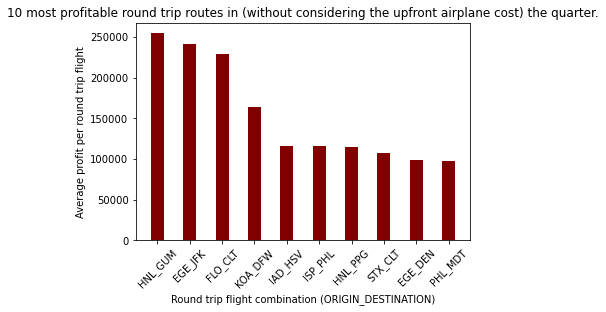

In [17]:
# creating the bar plot
plt.bar(agg1.ORIGIN_DESTINATION[:10], agg1.TOTAL_PROFIT_mean[:10], color ='maroon',
        width = 0.4)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel("Round trip flight combination (ORIGIN_DESTINATION)")
plt.ylabel("Average profit per round trip flight")
plt.title("10 most profitable round trip routes in (without considering the upfront airplane cost) the quarter.")
plt.show()

### Exercise 3
The 5 round trip routes that you recommend to invest in based on any factors that you
choose. There are two main featuers that define the worth of investing in a roundtrip flight; its traffic and its average profit. The column <strong>FACTOR</strong> <br> which is equal to multiplying the total number of flights of every round trip flight with its corresponding average profit, encapsulates both features.

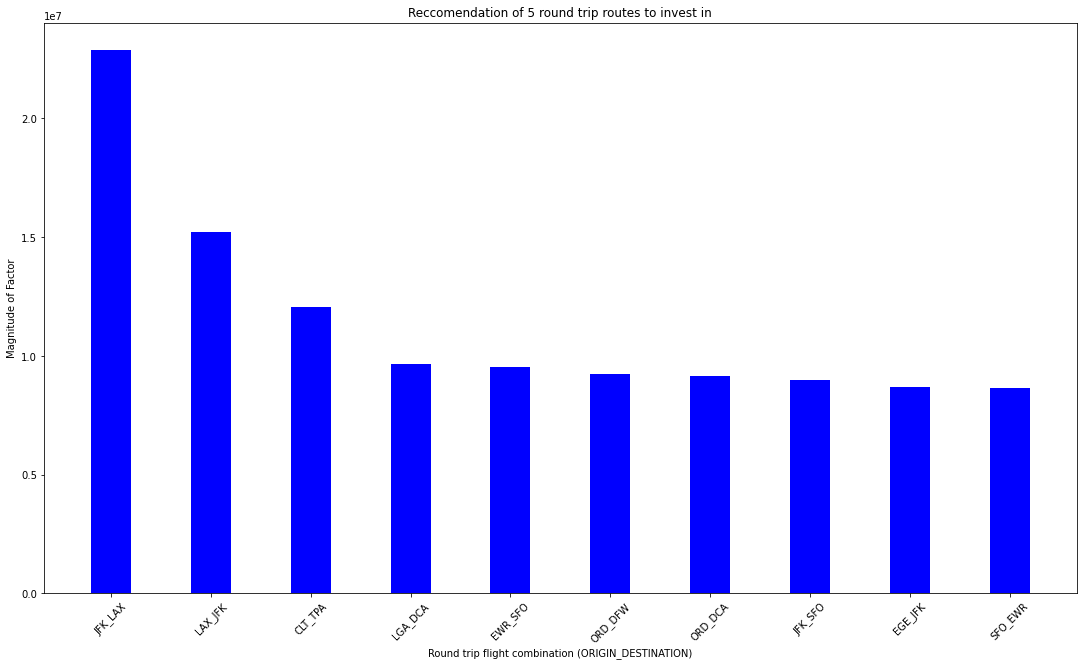

In [18]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
agg1['FACTOR'] = agg1['TOTAL_PROFIT_mean'] * agg1['NO_FLIGHTS']
agg1 = agg1.sort_values(by='FACTOR', ascending=False)
agg1_recc = agg1[:10]
# creating the bar plot
plt.bar(agg1_recc.ORIGIN_DESTINATION, agg1_recc.FACTOR, color ='blue',width = 0.4)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel("Round trip flight combination (ORIGIN_DESTINATION)")
plt.ylabel("Magnitude of Factor")
plt.title("Reccomendation of 5 round trip routes to invest in")
plt.show()

### Exercise 4
The number of round trip flights it will take to breakeven on the upfront airplane cost for
each of the 5 round trip routes that you recommend. Print key summary components for
these routes

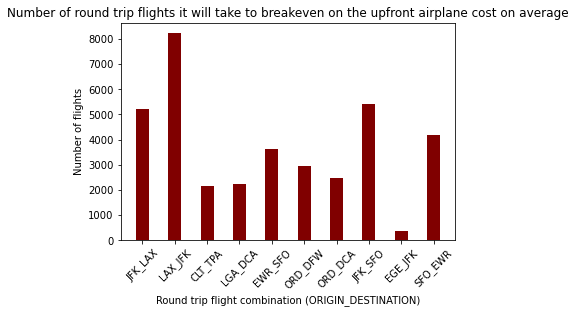

In [19]:
upfront_airplane_cost = 90*(10**6)
agg1_recc['NO_FLIGHTS_BREAKEVEN'] = (upfront_airplane_cost/agg1_recc['TOTAL_PROFIT_mean']).astype(int)

# creating the bar plot
plt.bar(agg1_recc.ORIGIN_DESTINATION, agg1_recc.NO_FLIGHTS_BREAKEVEN, color ='maroon',
        width = 0.4)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel("Round trip flight combination (ORIGIN_DESTINATION)")
plt.ylabel("Number of flights")
plt.title("Number of round trip flights it will take to breakeven on the upfront airplane cost on average")
plt.show()

In [20]:
df_summary = agg1_recc[['NO_FLIGHTS','ORIGIN_DESTINATION','TOTAL_REVENUE_mean','TOTAL_COST_mean','TOTAL_PROFIT_mean','NO_FLIGHTS_BREAKEVEN','FACTOR']]
df_summary.to_csv('df_summary')

### Exercise 5
Key Performance Indicators (KPI’s) that you recommend tracking in the future to
measure the success of the round trip routes that you recommend. Applying the log fuction to the FACTOR variable yields a new feature that is more concise. Moreover, logarithmic transformations are used to "normalize" skewed or kurtotic distributions of continuous variables so that parametric statistics can be conducted.

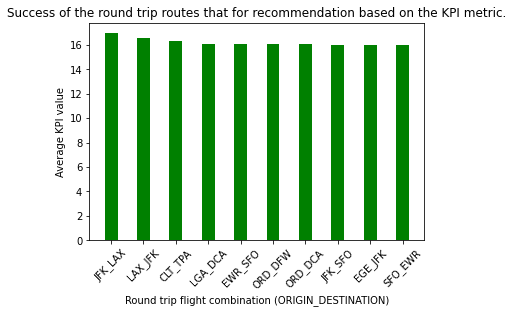

In [21]:
agg1_recc['KPI'] = np.log(1+agg1_recc.FACTOR)
# creating the bar plot
plt.bar(agg1_recc.ORIGIN_DESTINATION, agg1_recc.KPI, color ='green',
        width = 0.4)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel("Round trip flight combination (ORIGIN_DESTINATION)")
plt.ylabel("Average KPI value")
plt.title("Success of the round trip routes that for recommendation based on the KPI metric.")
plt.show()

# What’s Next
What you would do next to inform a better decision or deliver a better product to your company. 
1. Flight combinations (using the same plane) with 3 or more airports involved should be investigated. Our current assumptions are limiting and should be adjusted for more exploration.
2. Conduct the analysis using shorter time-intervals to find which are the most profitable flights. The current time interval which we are investigating is the first quarter of 2019. Smaller timer intervals such as monthly, could be investigated to find which are routes that yield the maximum amount of profit for every fixed time interval.
3. Other datasets should be used to fill in the missing values (f.e IATA_CODE column in airports dataset)
4. Include measurements of uncertainty regarding the KPI column (f.e confidence intervals).